## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
group_data = data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
print('Начало наблюдений для группы A: {}, окончание наблюдений: {}'.format(group_data[group_data['group'] == 'A']['date'].min(), group_data[group_data['group'] == 'A']['date'].max()))
print('Начало наблюдений для группы B: {}, окончание наблюдений: {}'.format(group_data[group_data['group'] == 'B']['date'].min(), group_data[group_data['group'] == 'B']['date'].max()))





Начало наблюдений для группы A: 2021-01-02 00:00:00, окончание наблюдений: 2021-01-24 00:00:00
Начало наблюдений для группы B: 2021-01-02 00:00:00, окончание наблюдений: 2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# вычисляем кумулятивную сумму количества посетителей
group_data['cum_users_count'] = group_data.groupby(['group'])['users_count'].cumsum()
group_data['cum_purchase'] = group_data.groupby(['group'])['purchase'].cumsum()
group_data['cum_price'] = round(group_data.groupby(['group'])['price'].cumsum()/1000000, 2)
maskD = group_data['date'] == '2021-01-24'
display(group_data[maskD][['group','users_count','cum_purchase','cum_price']].rename(columns={'group':'Группа', 'users_count': 'Количество посещений', 'cum_purchase':'Суммарное количество покупок', 'cum_price':'Сумма всех покупок'}))



,Группа,Количество посещений,Суммарное количество покупок,Сумма всех покупок
22,A,3811,17723,1436.26
45,B,3727,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
a_set = data[data['group'] == 'A']['user_id']
a_set = set(a_set)
display(len(a_set))

b_set = data[data['group'] == 'B']['user_id']
b_set = set(b_set)
display(len(b_set))

user_intersection = a_set.intersection(b_set)
display('Количество пользователей, входящих в обе группы : {}'.format(len(user_intersection)))


146195

146284

'Количество пользователей, входящих в обе группы : 1895'

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

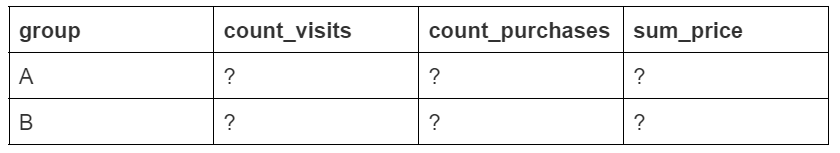
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
group_data = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count','purchase':'count_purchases','price':'sum_price'})
display(group_data)

,group,users_count,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

По построенной таблице можно сделать несколько выводов:
1. количество посещений обоих вариантов посадочной страницы достаточно для проведения A/B теста (Калькулятор Эвана Миллера);
2. количество посещений обоих вариантов посадочной страницы сопоставимо (распределение с точностью до 2 знака после запятой составляет 50/50), т.е. можно говорить о сбалансированности выборок с учетом того, что у нас нет никаких других характеристик пользователей.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
group_data['conversion'] = round(group_data['count_purchases']/group_data['users_count']*100,2)
group_data['mean_check'] = round(group_data['sum_price']/group_data['count_purchases'])
display(group_data)


,group,users_count,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

По конверсии вариант A эффективней варианта B. Средний чек дает обратный вариант - вариант B эффективней варианта A.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
purchase_data = pd.pivot_table(updated_data,
index = ['group'],
columns=['price'],
values = ['purchase'],
aggfunc=['sum']
)

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

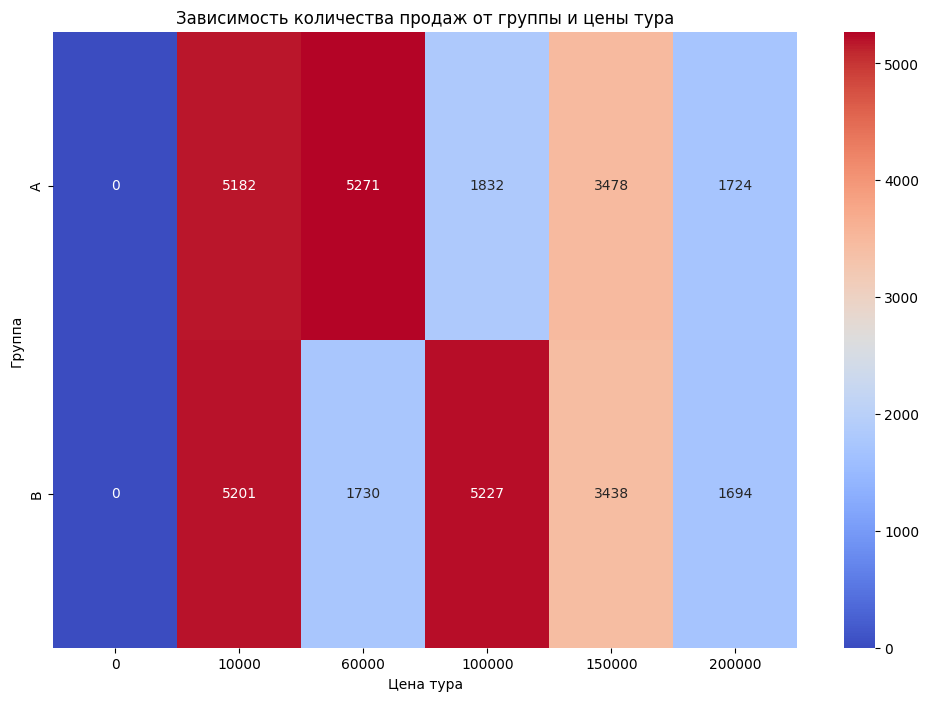

In [11]:
plt.figure(figsize = (12, 8))
heatmap = sns.heatmap(purchase_data, annot=True, fmt='.0f', cmap='coolwarm')
heatmap.set(title='Зависимость количества продаж от группы и цены тура', xlabel='Цена тура', ylabel='Группа')
heatmap.set_xticklabels([0, 10000, 60000, 100000, 150000, 200000], rotation = 0)
plt.show()

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Анализ тепловой карты зависимости количества продаж от группы и цены тура показывает, что основная разница в покупках приходится на туры стоимостью 60 000 руб. (Турция) и 100 000 руб. (Таиланд). Участники группы A отдают предпочтение Турции (соотношение почти 3:1), а участники группы B - Таиланду (соотношение чуть меньше 3:1). Для остальных туров предпочтения участников практически совпадают.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
gr_data = updated_data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count', 'purchase':'count_purchases', 'price':'sum_price'})

gr_data['daily_purchase'] = round(gr_data['count_purchases']/gr_data['users_count']*100, 2)
gr_data['daily_price'] = round(gr_data['sum_price']/gr_data['count_purchases'])


display(gr_data[gr_data['date'] == '2021-01-03'])


,group,date,users_count,count_purchases,sum_price,daily_purchase,daily_price
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
gr_data_cum = updated_data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count','purchase':'count_purchases','price':'sum_price'})

gr_data_cum['cum_users_count'] = gr_data_cum.groupby(['group'])['users_count'].cumsum()
gr_data_cum['cum_count_purchases'] = gr_data_cum.groupby(['group'])['count_purchases'].cumsum()
gr_data_cum['cum_sum_price'] = gr_data_cum.groupby(['group'])['sum_price'].cumsum()
gr_data_cum['conversion'] = round(gr_data_cum['cum_count_purchases']/gr_data_cum['cum_users_count']*100, 2)
gr_data_cum['mean_check'] = round(gr_data_cum['cum_sum_price']/gr_data_cum['cum_count_purchases'])

display(gr_data_cum)


,group,date,users_count,count_purchases,sum_price,cum_users_count,cum_count_purchases,cum_sum_price,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,9450,1107,91410000,11.71,82575.0
2,A,2021-01-04,6566,799,64250000,16016,1906,155660000,11.90,81668.0
3,A,2021-01-05,6433,790,64550000,22449,2696,220210000,12.01,81680.0
4,A,2021-01-06,6606,764,63410000,29055,3460,283620000,11.91,81971.0
5,A,2021-01-07,6579,795,67290000,35634,4255,350910000,11.94,82470.0
6,A,2021-01-08,6687,798,65380000,42321,5053,416290000,11.94,82385.0
7,A,2021-01-09,6633,794,65610000,48954,5847,481900000,11.94,82418.0
8,A,2021-01-10,6659,759,58950000,55613,6606,540850000,11.88,81873.0
9,A,2021-01-11,6699,797,58760000,62312,7403,599610000,11.88,80996.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

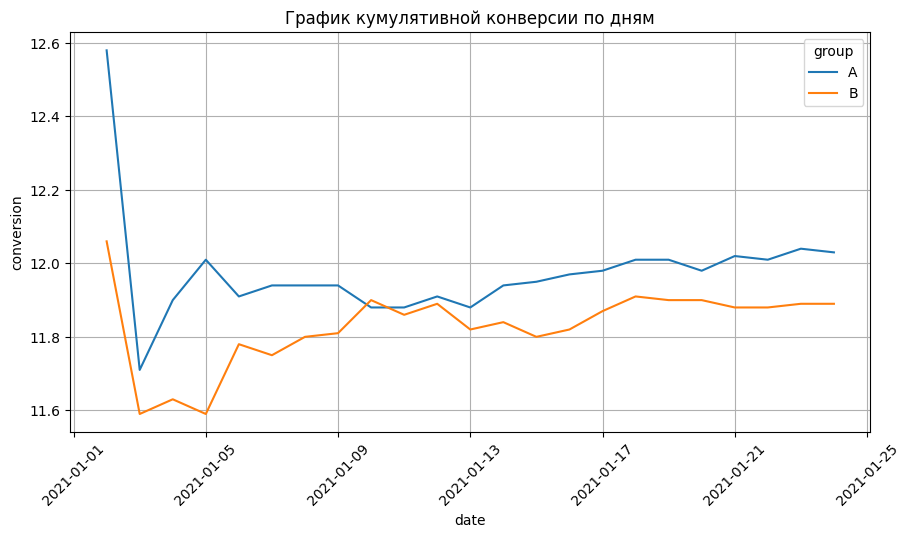

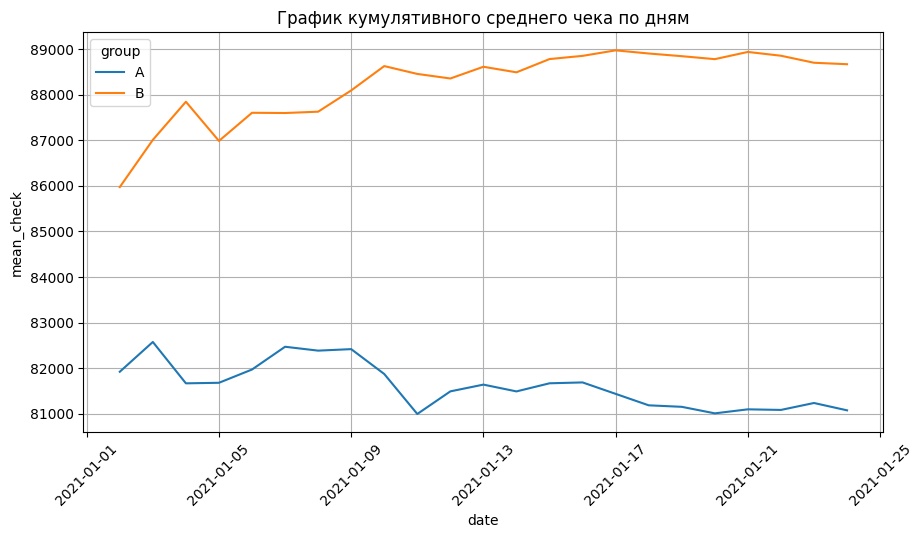

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='conversion', data=gr_data_cum, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='mean_check', data=gr_data_cum, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

A/B-тест можно считать завершенным, т.к. с 12-13 января 2021 года значения метрик в обеих группах стабилизировались. При этом после 10 января 2021 года кумулятивная конверсия в группе A превышает кумулятивную конверсию в группе B. Кумулятивный средний чек в группе B стабильно превосходит аналогичный показатель в группе A на всем интервале тестирования.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=group_data['count_purchases'], #число "успехов"
    nobs=group_data['users_count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

В результате проведенного статистического теста принимается нулевая гипотеза: "Конверсии в группах А и B равны", т.к. при уровне значимости &alpha;=0.05 <i>p-value</i>>&alpha; (0,12 > 0,05).

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p*(1 - x_p)/n)**0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound*100, 2), round(upper_bound*100, 2)

conf_interval_a = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'A']['user_id'].count(), # размер выборки для A
x_p=updated_data[updated_data['group'] == 'A']['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=updated_data[updated_data['group'] == 'B']['user_id'].count(), # размер выборки для B
x_p=updated_data[updated_data['group'] == 'B']['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [17]:
def diff_proportions_conf_interval(n, xp, gamma = 0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit*(xp[0]*(1 - xp[0])/n[0] + xp[1]*(1 - xp[1])/n[1])**0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    return round(lower_bound*100, 2), round(upper_bound*100, 2)

# размеры выборок групп А и B
n = [updated_data[updated_data['group'] == 'A']['user_id'].count(), updated_data[updated_data['group'] == 'B']['user_id'].count()]
# выборочная пропорция групп A и B
xp = [updated_data[updated_data['group'] == 'A']['purchase'].mean(), updated_data[updated_data['group'] == 'B']['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы для конверсий в группах A и B имеют перекрытие. Доверительный интервал для разности конверсий: (-0.38, 0.09). Это говорит о том, что статистическая разница конверсиями в группах А и B отсутствует (интервал имеет на концах разные знаки).

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [18]:
up_data = updated_data.groupby(['group','date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count','purchase':'count_purchases','price':'sum_price'})
up_data['mean_check'] = up_data['sum_price']/up_data['count_purchases']

In [19]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(up_data[up_data['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(up_data[up_data['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))



p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [20]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=up_data[up_data['group'] == 'A']['mean_check'],
    b=up_data[up_data['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Проведенный статистический тест опровергает гипотезу о равенстве ежедневных средних чеках в группах A и B. Таким образом, принимается альтернативная гипотеза о том, что ежедневный средний чек в группе А меньше чем в группе B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [21]:
import statistics as s
from scipy.stats import t

gamma = 0.95
alpha = 1 - gamma

n = up_data[up_data['group'] == 'A'].shape[0]
k = n - 1
x_mean = s.mean(up_data[up_data['group'] == 'A']['mean_check'])
x_std = s.stdev(up_data[up_data['group'] == 'A']['mean_check'],x_mean)

t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps
upper_bound = x_mean + eps
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал для группы A: {}'.format(confidence_interval)) # выводим результат

n = up_data[up_data['group'] == 'B'].shape[0]
k = n - 1
x_mean = s.mean(up_data[up_data['group'] == 'B']['mean_check'])
x_std = s.stdev(up_data[up_data['group'] == 'B']['mean_check'],x_mean)

t_crit = -t.ppf(alpha/2, k)
eps = t_crit * x_std/(n**0.5)
lower_bound = x_mean - eps
upper_bound = x_mean + eps
confidence_interval = (round(lower_bound), round(upper_bound))
print('Доверительный интервал для группы B: {}'.format(confidence_interval))


Доверительный интервал для группы A: (79630, 82308)
Доверительный интервал для группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы для ежедневных средних чеков в группах A и B различны. Они не имеют пересечения. Это говорит о наличии статистической разницы между ежедневными средними чеками в группах А и B.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По результатам тестов хочется сделать вывод о более эффективном дизайне посадочной страницы "B" официально сайта. Такое желание связано с результатами тестирования ежедневного среднего чека. В группе B результат выше, чем в группе A, и этот результат является статистически значимым. В то же время конверсии в группах с точки зрения статистики равны.
Кроме того, необходимо вспомнить тепловую карту зависимости количества продаж от группы и цены тура. Из этой карты можно сделать вывод о том, что конверсия в группах одинаковая, а разница в ежедневном среднем чеке между группами образуется из-за предпочтений участников групп, при которых пользователи группы B отдают предпочтение более дорогому туру в Таиланд.
Таким образом, оба варианта посадочных страниц официального сайта равнозначны с точки зрения задачи продать как можно больше туров. Рекомендуется пересмотреть распределение пользователей по группам и провести A/B тестирование повторно.